## Find the 400 nearest turbines in area DK1 to the first turbine based on their UTM coordinates using the Nearest Neighbors algorithm.

this takes 1m 20.4S

In [11]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

# ================================
# Step 1: read settlement and filter turbines
# ================================
settlement = pd.read_parquet("energinet/settlement/2019.parquet")

# convert VAERDI to numeric, coerce errors to NaN
settlement["VAERDI"] = pd.to_numeric(settlement["VAERDI"], errors="coerce")

# compute mean power per GSRN and filter those with mean > 0
mean_power_per_gsrn = settlement.groupby("GSRN")["VAERDI"].mean()
valid_gsrns = set(mean_power_per_gsrn[mean_power_per_gsrn > 0].index)

# ================================
# Step 2: read masterdatawind and filter turbines
# ================================
df = pd.read_parquet("energinet/masterdatawind.parquet")

# keep only W-type turbines with valid UTM coordinates and in valid_gsrns
df = df[
    (df["Turbine_type"] == "W") &
    (df["UTM_x"].notnull()) &
    (df["UTM_y"].notnull()) &
    (df["GSRN"].isin(valid_gsrns))
].copy()

# drop duplicates, keep the earliest In_service date
df = df.sort_values("In_service").drop_duplicates(subset="GSRN", keep="first")

# ================================
# Step 3: Nearest Neighbors selection
# ================================
coords = df[["UTM_x", "UTM_y"]].values
model = NearestNeighbors(n_neighbors=200, algorithm='ball_tree').fit(coords)
_, indices = model.kneighbors([coords[0]])

# select the 200 turbines
selected = df.iloc[indices[0]].copy()

# ================================
# Step 4: output results
# ================================
print("Selected 200 W-type turbines with non-zero generation in 2019:")
print(selected[["GSRN", "Turbine_name", "UTM_x", "UTM_y", "Capacity_kw", "In_service"]])

# save to CSV
selected.to_csv("selected_200_turbines_filtered.csv", index=False)

Selected 200 W-type turbines with non-zero generation in 2019:
                     GSRN                Turbine_name       UTM_x       UTM_y  \
85087  571313174116253585  Frederiksborgvej 399, 4000  694932.000  6.1755e+06   
10617  570714700000106958       Forskningscenter Risø  694694.000  6.1754e+06   
1747   570714700000004575       Forskningscenter Risø  694665.000  6.1755e+06   
1776   570714700000004605      Klaus Hartmann Nielsen  697337.000  6.1744e+06   
1740   570714700000004568      Kongemarkens Vindmølle  689965.000  6.1712e+06   
...                   ...                         ...         ...         ...   
8059   570714700000013249                 MADS MADSEN  717049.412  6.1313e+06   
8046   570714700000013232             JØRGEN PETERSEN  717015.391  6.1311e+06   
7440   570714700000012563              Vestmarken 1 V  648601.900  6.1576e+06   
2289   570714700000005381              Vestmarken 1 V  648588.800  6.1575e+06   
2251   570714700000005350              Vestmar

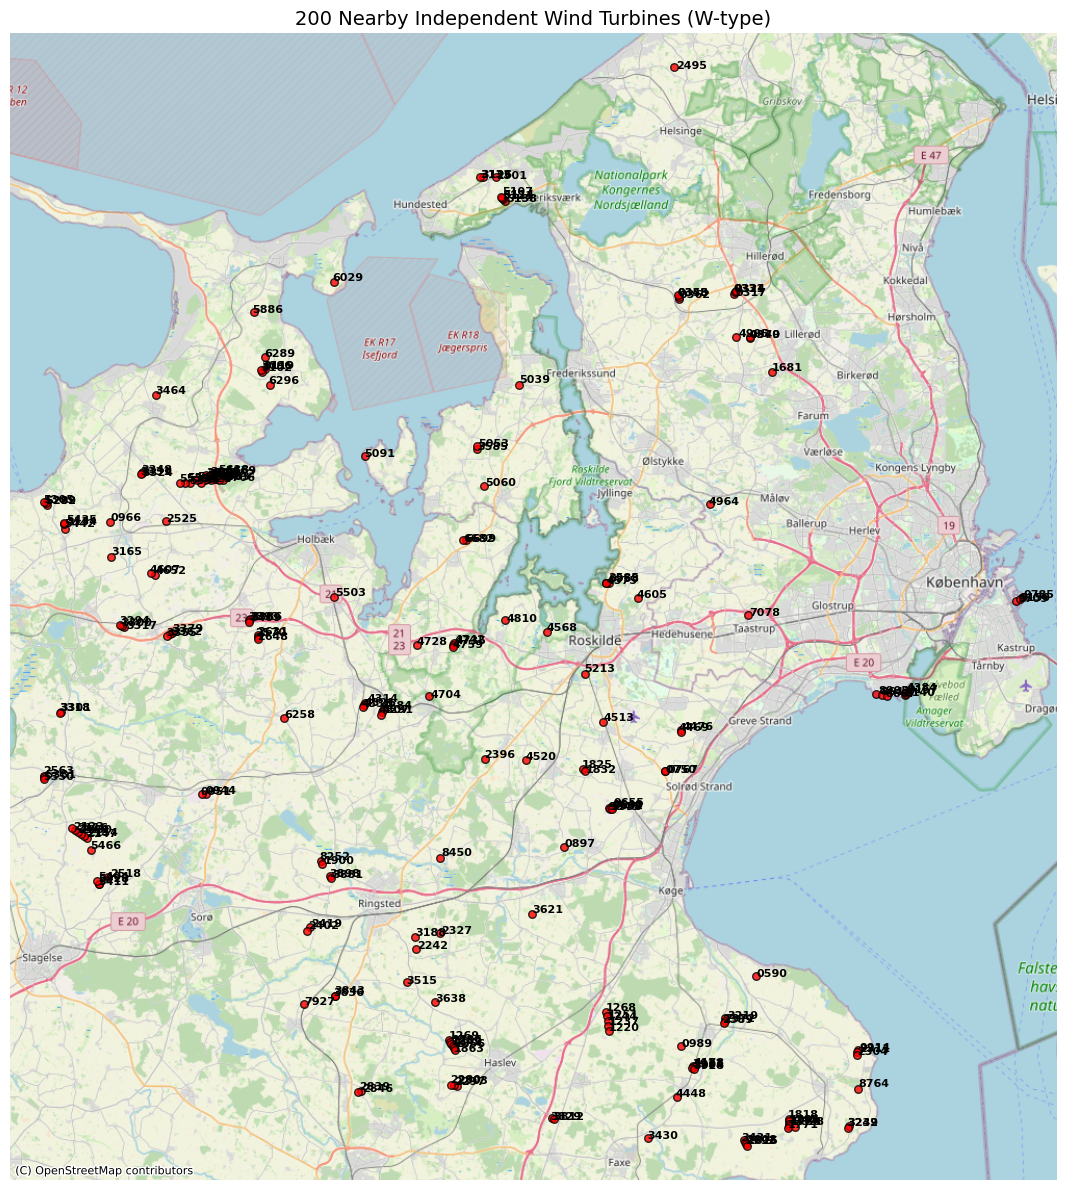

In [12]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import random

# create a GeoDataFrame from selected turbines
selected_gdf = gpd.GeoDataFrame(
    selected,
    geometry=gpd.points_from_xy(selected["UTM_x"], selected["UTM_y"]),
    crs="EPSG:25832"
)

# transform to Web Mercator for plotting with contextily
selected_gdf = selected_gdf.to_crs(epsg=3857)

# draw
fig, ax = plt.subplots(figsize=(12, 12))  # 更大画布

# draw points for turbines
selected_gdf.plot(ax=ax, color='red', markersize=30, edgecolor='black', alpha=0.8)

# add labels with slight random offset to avoid overlap
for idx, row in selected_gdf.iterrows():
    gsrn_suffix = str(row["GSRN"])[-4:]
    dx = random.randint(-300, 300)
    dy = random.randint(-300, 300)
    ax.text(row.geometry.x + dx, row.geometry.y + dy, gsrn_suffix,
            fontsize=8, color='black', weight='bold')

# set auto limits with extra padding to zoom out
ax.set_xlim(selected_gdf.total_bounds[0] - 5000, selected_gdf.total_bounds[2] + 5000)
ax.set_ylim(selected_gdf.total_bounds[1] - 5000, selected_gdf.total_bounds[3] + 5000)

# add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# finalize plot by removing axes and adding title
plt.axis("off")
plt.title("200 Nearby Independent Wind Turbines (W-type)", fontsize=14)
plt.tight_layout()
plt.show()

this takes 59.8s

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ---------- STEP 1: read selected turbines ----------
selected_gsrns = [str(g) for g in selected["GSRN"].tolist()]

# ---------- STEP 2: read settlement and filter turbines ----------
settlement = pd.read_parquet("energinet/settlement/2019.parquet")
settlement["GSRN"] = settlement["GSRN"].astype(str)
df_settle = settlement[settlement["GSRN"].isin(selected_gsrns)].copy()

# ---------- STEP 3: parse time fields ----------
df_settle["timestamp"] = pd.to_datetime(df_settle["TIME_CET"])
df_settle["hour"] = df_settle["timestamp"].dt.hour
df_settle["date"] = df_settle["timestamp"].dt.date

# ---------- STEP 4: feature engineering ----------
feature_list = []

for gsrn, group in df_settle.groupby("GSRN"):
    power = pd.to_numeric(group["VAERDI"], errors="coerce")  # NaNs will be kept
    mean_power = power.mean()
    std_power = power.std()
    cv = std_power / mean_power if mean_power else None
    zero_ratio = (power == 0).mean()
    ramp_rate = power.diff()
    ramp_mean = ramp_rate.mean()
    ramp_std = ramp_rate.std()

    feature_list.append({
        "GSRN": gsrn,
        "mean_power": mean_power,
        "std_power": std_power,
        "cv": cv,
        "zero_ratio": zero_ratio,
        "ramp_mean": ramp_mean,
        "ramp_std": ramp_std,
    })

features_df = pd.DataFrame(feature_list)

# ---------- STEP 5: check and drop invalid turbines ----------
print(" Initial turbine count:", len(features_df))
invalid_rows = features_df[features_df.isna().any(axis=1) | (features_df["mean_power"] == 0)]
if not invalid_rows.empty:
    print("\n Turbines with invalid feature values (NaN or mean_power=0):")
    print(invalid_rows[["GSRN", "mean_power", "std_power", "cv", "ramp_mean"]])

features_df = features_df.dropna().copy()
features_df = features_df[features_df["mean_power"] != 0].copy()
print(" Valid turbines retained:", len(features_df))

# ---------- STEP 6: feature scaling ----------
columns_to_scale = ["mean_power", "std_power", "cv", "ramp_mean", "ramp_std"]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(features_df[columns_to_scale])

scaled_df = pd.DataFrame(scaled_values, columns=[f"{col}_scaled" for col in columns_to_scale])
scaled_df["GSRN"] = features_df["GSRN"].values  # ensure alignment

# Combine original and scaled
features_df = features_df.merge(scaled_df, on="GSRN")

# ---------- STEP 7: output and save ----------
pd.set_option("display.precision", 4)
print("\n Final scaled features preview:")
print(features_df.head())

output_path = "features_in_group_stage_200_turbines.csv"
features_df.to_csv(output_path, index=False)
print(f"\n  Features saved to: {output_path}")

 Initial turbine count: 200
 Valid turbines retained: 200

 Final scaled features preview:
                 GSRN  mean_power  std_power      cv  zero_ratio  ramp_mean  \
0  570714700000000140    123.6282   177.3256  1.4343      0.3548     0.0171   
1  570714700000000157    134.0462   170.9980  1.2757      0.2666     0.0030   
2  570714700000000317    110.9197   139.2738  1.2556      0.1346     0.0047   
3  570714700000000324    103.4258   135.3497  1.3087      0.1533     0.0024   
4  570714700000000331    102.1115   134.7164  1.3193      0.1679    -0.0062   

   ramp_std  mean_power_scaled  std_power_scaled  cv_scaled  ramp_mean_scaled  \
0   58.6510            -0.3360           -0.2304    -0.0662            0.5776   
1   65.2574            -0.2989           -0.2547    -0.1056            0.2929   
2   45.0494            -0.3812           -0.3765    -0.1106            0.3273   
3   45.4840            -0.4078           -0.3916    -0.0974            0.2807   
4   44.5871            -0.412

this takes 2m 5.6s

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ---------- Step 0: get selected turbines ----------
selected["GSRN"] = selected["GSRN"].astype(str)
selected_gsrns = selected["GSRN"].tolist()
capacity_map = dict(zip(selected["GSRN"], selected["Capacity_kw"]))

# ---------- Step 1: load power generation data ----------
settlement = pd.read_parquet("energinet/settlement/2019.parquet")
settlement["timestamp"] = pd.to_datetime(settlement["TIME_CET"])
settlement["VAERDI"] = pd.to_numeric(settlement["VAERDI"], errors="coerce")
settlement["GSRN"] = settlement["GSRN"].astype(str)
settlement = settlement[settlement["GSRN"].isin(selected_gsrns)].copy()

# Normalize VAERDI by Capacity_kw
settlement["Capacity_kw"] = settlement["GSRN"].map(capacity_map)
settlement["VAERDI_norm"] = settlement["VAERDI"] / settlement["Capacity_kw"]

# ---------- Step 2: load wind speed data and flatten ----------
raw_wind = pd.read_parquet("energinet/prognosis/ENetNEA/wind_speed_100m.parquet")
wind_long = raw_wind.drop(columns=["predicted_ahead"]).copy()
wind_long = wind_long.melt(var_name="offset_hour", value_name="wind_speed")
wind_long["offset_hour"] = pd.to_numeric(wind_long["offset_hour"], errors="coerce")
base_time = pd.Timestamp("2019-01-01 00:00:00")
wind_long["timestamp"] = base_time + pd.to_timedelta(wind_long["offset_hour"], unit="h")
avg_wind = wind_long.groupby("timestamp")["wind_speed"].mean().reset_index()

# ---------- Step 3: merge two data sources ----------
merged = pd.merge(
    settlement[["GSRN", "timestamp", "VAERDI_norm"]],
    avg_wind,
    on="timestamp",
    how="inner"
).dropna()

# ---------- Step 4: extract features for each turbine ----------
results = []

for gsrn, group in merged.groupby("GSRN"):
    group = group.sort_values("timestamp").copy()

    # Feature 1: Residual MSE by Wind Speed bin
    group["wind_bin"] = pd.cut(group["wind_speed"], bins=np.arange(0, 26, 2))
    residuals = []

    for _, bin_df in group.groupby("wind_bin", observed=True):
        if len(bin_df) >= 5:
            x = bin_df[["wind_speed"]]
            y = bin_df["VAERDI_norm"]
            model = LinearRegression().fit(x, y)
            y_pred = model.predict(x)
            mse = mean_squared_error(y, y_pred)
            residuals.append(mse)

    residual_mse = np.mean(residuals) if residuals else np.nan

    # Feature 2: Daily Power Curve
    group["hour"] = group["timestamp"].dt.hour
    hourly_mean = group.groupby("hour")["VAERDI_norm"].mean().reindex(range(24), fill_value=np.nan)
    daily_profile = hourly_mean.values

    # Feature 3: Fourier components
    fourier_coeffs = np.fft.fft(daily_profile)
    fourier_features = np.abs(fourier_coeffs[:5])

    results.append({
        "GSRN": gsrn,
        "residual_mse": residual_mse,
        **{f"hour_{i}": v for i, v in enumerate(daily_profile)},
        **{f"fft_{i}": v for i, v in enumerate(fourier_features)}
    })

# ---------- Step 5: output results and save to CSV ----------
features_df = pd.DataFrame(results)
pd.set_option("display.precision", 4)
print(features_df.head())

features_df.to_csv("power_curve_features_in_group_stage_200_turbines.csv", index=False)

                 GSRN  residual_mse  hour_0  hour_1  hour_2  hour_3  hour_4  \
0  570714700000000140        0.0412  0.1427  0.1650  0.2089  0.2109  0.1960   
1  570714700000000157        0.0385  0.1368  0.1794  0.2185  0.1873  0.1928   
2  570714700000000317        0.0286  0.1593  0.1590  0.1600  0.1647  0.1720   
3  570714700000000324        0.0257  0.1479  0.1522  0.1529  0.1599  0.1646   
4  570714700000000331        0.0217  0.1367  0.1384  0.1319  0.1297  0.1422   

   hour_5  hour_6  hour_7  ...  hour_19  hour_20  hour_21  hour_22  hour_23  \
0  0.2219  0.2018  0.1844  ...   0.1636   0.1432   0.1855   0.2274   0.1684   
1  0.2239  0.1937  0.1559  ...   0.1433   0.1262   0.1857   0.2072   0.1541   
2  0.2045  0.1715  0.1691  ...   0.1382   0.1546   0.1720   0.2070   0.1788   
3  0.1877  0.1403  0.1299  ...   0.1387   0.1549   0.1654   0.1884   0.1788   
4  0.1571  0.1213  0.1197  ...   0.1326   0.1333   0.1123   0.1535   0.1702   

    fft_0   fft_1   fft_2   fft_3   fft_4  
0  4.9

/var/folders/rx/y63trwp10b9dm1lbhqqv7_rw0000gn/T/ipykernel_92562/1870968686.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', len(selected_gsrns))
/var/folders/rx/y63trwp10b9dm1lbhqqv7_rw0000gn/T/ipykernel_92562/1870968686.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # give space for legend on the right


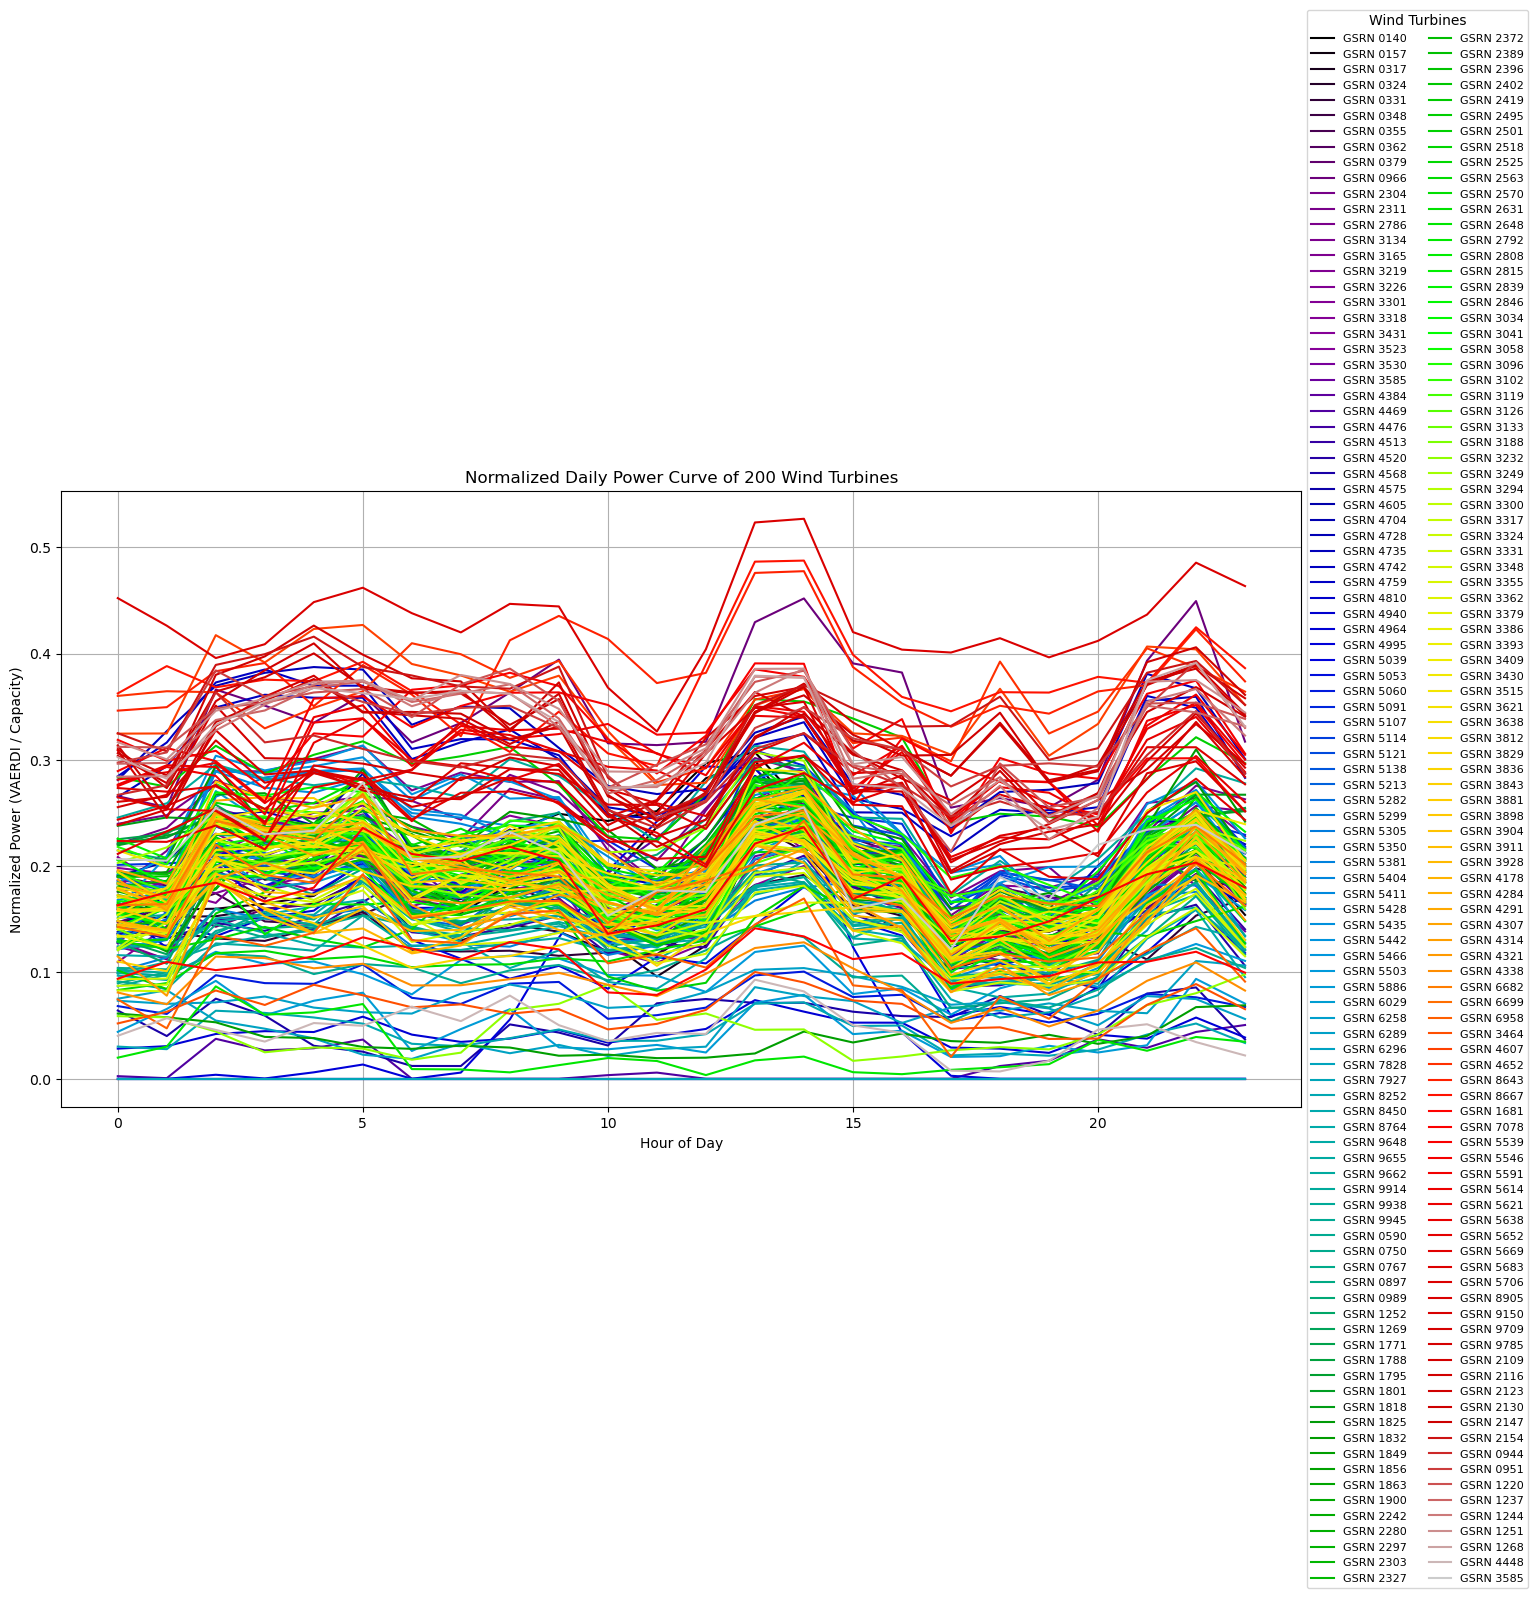

In [16]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# extract only turbines present in features_df
selected_gsrns = selected["GSRN"].astype(str).tolist()
features_df = features_df[features_df["GSRN"].isin(selected_gsrns)].copy()

# generate distinct colors
cmap = cm.get_cmap('nipy_spectral', len(selected_gsrns))
colors = [cmap(i) for i in range(len(selected_gsrns))]

# Create figure
plt.figure(figsize=(16, 8))

# Plot each curve
for i, (_, row) in enumerate(features_df.iterrows()):
    hours = list(range(24))
    values = [row[f"hour_{h}"] for h in hours]
    gsrn_suffix = str(row["GSRN"])[-4:]
    plt.plot(hours, values, label=f"GSRN {gsrn_suffix}", color=colors[i], linewidth=1.5)

# Plot formatting
plt.title("Normalized Daily Power Curve of 200 Wind Turbines")
plt.xlabel("Hour of Day")
plt.ylabel("Normalized Power (VAERDI / Capacity)")
plt.grid(True)

# Add legend: multi-column and outside to avoid overlap
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    ncol=2,
    fontsize=8,
    title="Wind Turbines"
)

# Final layout adjustments
plt.tight_layout(rect=[0, 0, 0.85, 1])  # give space for legend on the right
plt.show()

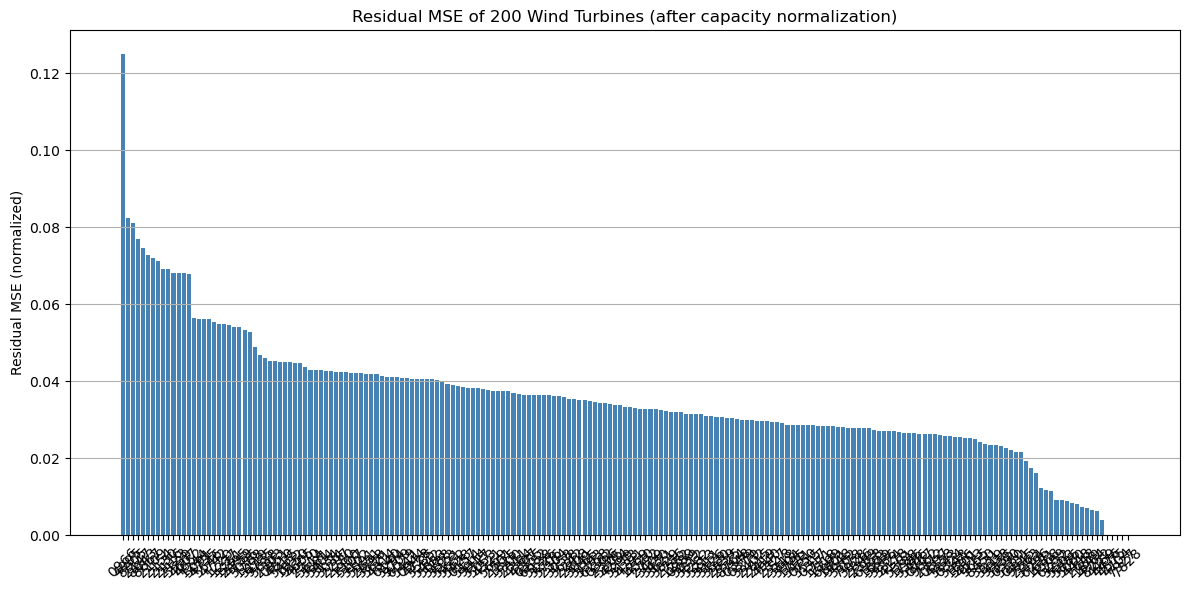

In [17]:
import matplotlib.pyplot as plt

# order by residual_mse descending
features_sorted = features_df.sort_values("residual_mse", ascending=False)

# draw bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    features_sorted["GSRN"].astype(str).str[-4:],  # 只显示 GSRN 后4位
    features_sorted["residual_mse"],
    color="steelblue"
)
plt.xticks(rotation=45)
plt.ylabel("Residual MSE (normalized)")
plt.title("Residual MSE of 200 Wind Turbines (after capacity normalization)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()